# Probabilistic K-Nearest Neighbors

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons
from numpy.random import rand, randn, randint, seed
from sklearn.metrics import confusion_matrix, precision_score
from tqdm.notebook import tqdm

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

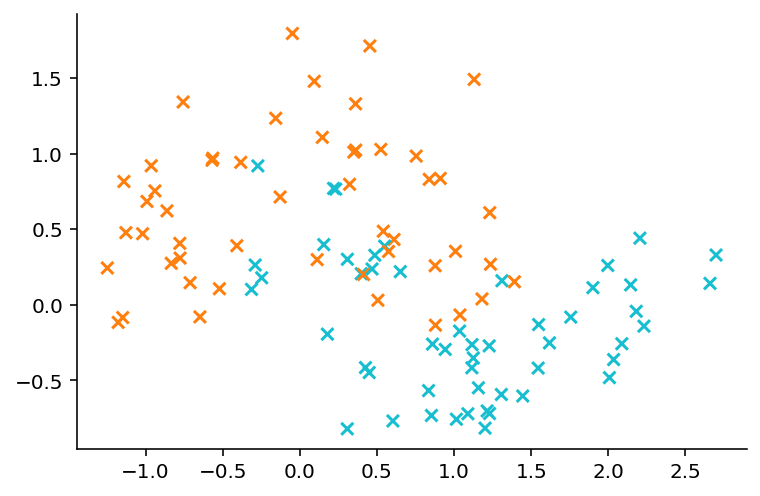

In [5]:
noise = 0.3
X, y = make_moons(101, noise=noise, random_state=314)
colors = ["tab:cyan" if yi else "tab:orange" for yi in y]
plt.scatter(*X.T, c=colors, marker="x")

## Plain Vanilla KNN

$$
    \hat t = \frac{1}{K}\sum_{n|x_n \in \mathcal{N}_K(x)} t_n
$$

In [6]:
x = np.array([0, 0])
k = 6
D = np.sum((x - X) ** 2, axis=1)

In [8]:
y[np.argsort(D)][:k].mean()

0.8333333333333334

In [9]:
# For three points
x = np.array([
    [0, 0],
    [1.5, -1],
    [-1, 1],
])

x.shape

(3, 2)

In [10]:
X.shape

(101, 2)

In [11]:
D = np.sum((x[:, None, :] - X[None, ...]) ** 2, axis=-1)
nearest = np.argsort(D)[:, :5]

In [12]:
nearest

array([[11, 25, 28, 34, 39],
       [38, 24, 50, 78, 61],
       [21, 35, 51, 36, 85]])

In [13]:
y[nearest].mean(axis=1)

array([0.8, 1. , 0. ])

In [14]:
k = 6

In [54]:
def knn(x, X, y, k=5):
    D = ((x[..., None] - X.T[:, None, None, :]) ** 2).sum(axis=0)
    nearest = np.argsort(D)[..., :k]
    nearest = y[nearest].mean(axis=-1)
    return nearest

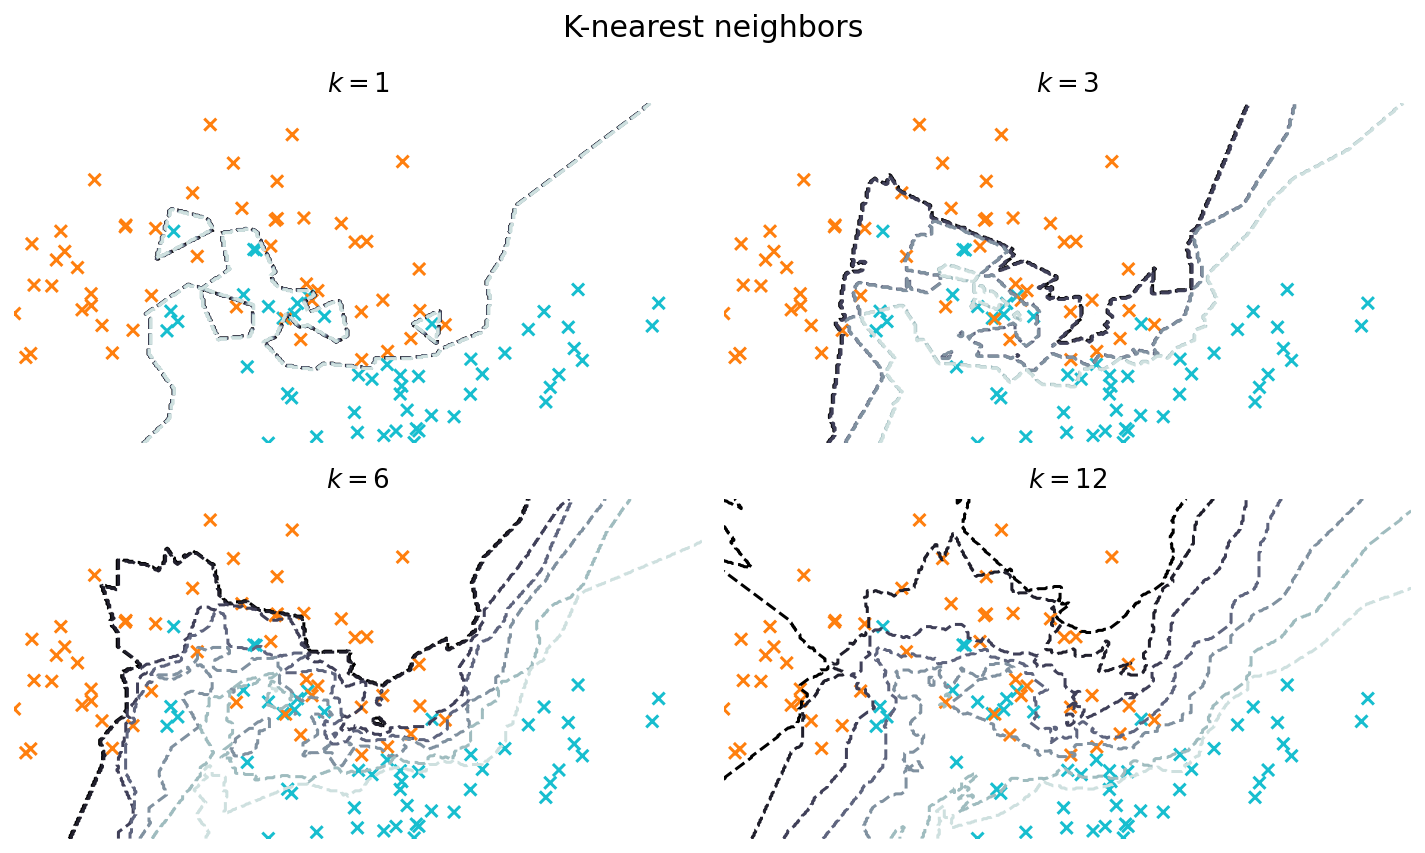

In [55]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
step = 0.009
grid = np.mgrid[xmin:xmax * 1.1:step, ymin:ymax * 1.1:step]

colors = ["tab:cyan" if yi else "tab:orange" for yi in y]

k_values = [1, 3, 6, 12]
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ax = ax.ravel()
for axi, k in zip(ax, k_values):    
    nearest = knn(grid, X, y, k=k)
    axi.axis("off")
    axi.contour(*grid, nearest, cmap="bone", linestyles="--")
    axi.set_title(f"$k={k}$", fontsize=13)
    axi.scatter(*X.T, c=colors, marker="x")
plt.suptitle("K-nearest neighbors", fontsize=15)
plt.tight_layout()

# Probabilistic KNN

Let $\mathcal D = \big\{(y_n, {\bf x}_n) \vert y_n \in \{c_q\}_{q=1}^Q, {\bf x}_n\in\mathbb{R}^M\big\}$

$$
    p(y_i \vert {\bf x}, \beta, k) = \frac{\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = y_i)\right)}{\sum_{q=1}^Q\exp\left(\frac{\beta}{k}\sum_{n\vert {\bf x}_n \in \mathcal{N}({\bf x}_i)}\mathbb{1}(y_n = q)\right)}
$$

In [17]:
k = 6
beta = 0.1
# Number of classes
Q = 2

In [18]:
X_cv, y_cv = make_moons(20, noise=noise, random_state=271)

In [19]:
def compute_distance(x, X):
    D = ((x[..., None] - X.T[:, None, :]) ** 2).sum(axis=0)
    return D

In [20]:
def find_k_closest(X, k=6):
    D = compute_distance(X.T, X)
    nearest = np.argsort(D)[..., 1 :k + 1]
    return nearest

In [21]:
# Comparing the "k" closest datapoints of xi to yi
num = y_cv[find_k_closest(X_cv, k=k)] == y_cv[:, None]
num = np.exp(beta * num.mean(axis=1))
num

array([1.06893911, 1.08690405, 1.06893911, 1.06893911, 1.08690405,
       1.08690405, 1.03389511, 1.01680633, 1.08690405, 1.06893911,
       1.08690405, 1.06893911, 1.06893911, 1.06893911, 1.06893911,
       1.06893911, 1.03389511, 1.03389511, 1.06893911, 1.0512711 ])

In [22]:
# N x K
den = y_cv[find_k_closest(X_cv, k=k), None] == np.arange(Q)[None, None, :]
den = np.exp(beta * den.mean(axis=1)).sum(axis=-1)
den

array([2.10283422, 2.10371038, 2.10283422, 2.10283422, 2.10371038,
       2.10371038, 2.10283422, 2.10371038, 2.10371038, 2.10283422,
       2.10371038, 2.10283422, 2.10283422, 2.10283422, 2.10283422,
       2.10283422, 2.10283422, 2.10283422, 2.10283422, 2.10254219])

In [23]:
likelihood = num / den
likelihood

array([0.50833256, 0.5166605 , 0.50833256, 0.50833256, 0.5166605 ,
       0.5166605 , 0.49166744, 0.4833395 , 0.5166605 , 0.50833256,
       0.5166605 , 0.50833256, 0.50833256, 0.50833256, 0.50833256,
       0.50833256, 0.49166744, 0.49166744, 0.50833256, 0.5       ])

In [24]:
def compute_likelihood(X, y, beta, k):
    Q = len(np.unique(y))
    # Comparing the "k" closest datapoints of xi to yi
    num = y[find_k_closest(X, k=k)] == y[:, None]
    num = np.exp(beta * num.mean(axis=1))
    
    den = y[find_k_closest(X, k=k), None] == np.arange(Q)[None, None, :]
    den = np.exp(beta * den.mean(axis=1)).sum(axis=-1)
    
    likelihood = num / den
    return likelihood.prod()

In [25]:
compute_likelihood(X_cv, y_cv, beta, k)

1.2182662708369252e-06

The predictive probability distribution for an unseen datapoint ${\bf x}_{n+1}$ is given by

$$
    p(y_{n+1}\vert {\bf x}_{n+1}, Y, X) = \sum_{k=1}^K\int p(y_{n + 1}\vert Y, X, \beta, k)p(\beta, k\vert Y, X) d\beta
$$

To approximate the predictive distribution, we first approximate the posterior $p(\beta,k\vert Y, X)$ as 

$$
    p(\beta, k\vert X, Y) \propto p(\beta)p(k)p(Y\vert X, \beta, k)
$$


Where
* $p(\beta) = c \cdot\mathbb{1}(\beta > 0)$
* $p(k) = \text{U}[1, \ldots, K]$; where $\text U$ is the discrete uniform distribution

### MCMC

To compute the posterior $p(\beta, k\vert X, Y)$, we take samples from the posterior using the metropolis-hastings method

In [26]:
def knn_mcmc(X, y, k, beta, target_samples=10_000, eta=1):
    samples = []
    n_rounds = 0
    while len(samples) < target_samples:
        n_rounds += 1
        beta_hat = np.abs(beta + randn() * eta)

        k_hat = np.abs(k + randint(-4, 4))
        k_hat = max(1, k_hat)

        L_hat = compute_likelihood(X, y, beta_hat, k_hat)
        L = compute_likelihood(X, y, beta, k)
        A = min(1, L_hat / L)
        if A > rand():
            samples.append([k_hat, beta_hat])
            k, beta = k_hat, beta_hat
    return np.array(samples), target_samples / n_rounds

> To choose [the] burn-in time we run two independent chains, one starting from
k = 1 and β = 10 and the other from k = kmax and β = 0:01, and we begin retaining samples
when the mean and variance of k and β become indistinguishable across the two chains within
a lag of 1000 samples from the current time

In [27]:
target_samples = 3_000
eta = 1.5

In [28]:
seed(3141)
samples_1, prop_accept = knn_mcmc(X, y, k=1, beta=10, target_samples=target_samples, eta=eta)
prop_accept

0.33123550844650546

In [29]:
seed(3141)
samples_2, prop_accept = knn_mcmc(X, y, k=30, beta=0.01, target_samples=target_samples, eta=eta)
print(prop_accept)

0.32171581769436997


In [30]:
N_range = np.arange(1, target_samples + 1)[:, None]
mu_1 = samples_1.cumsum(axis=0) / N_range
mu_2 = samples_2.cumsum(axis=0) / N_range

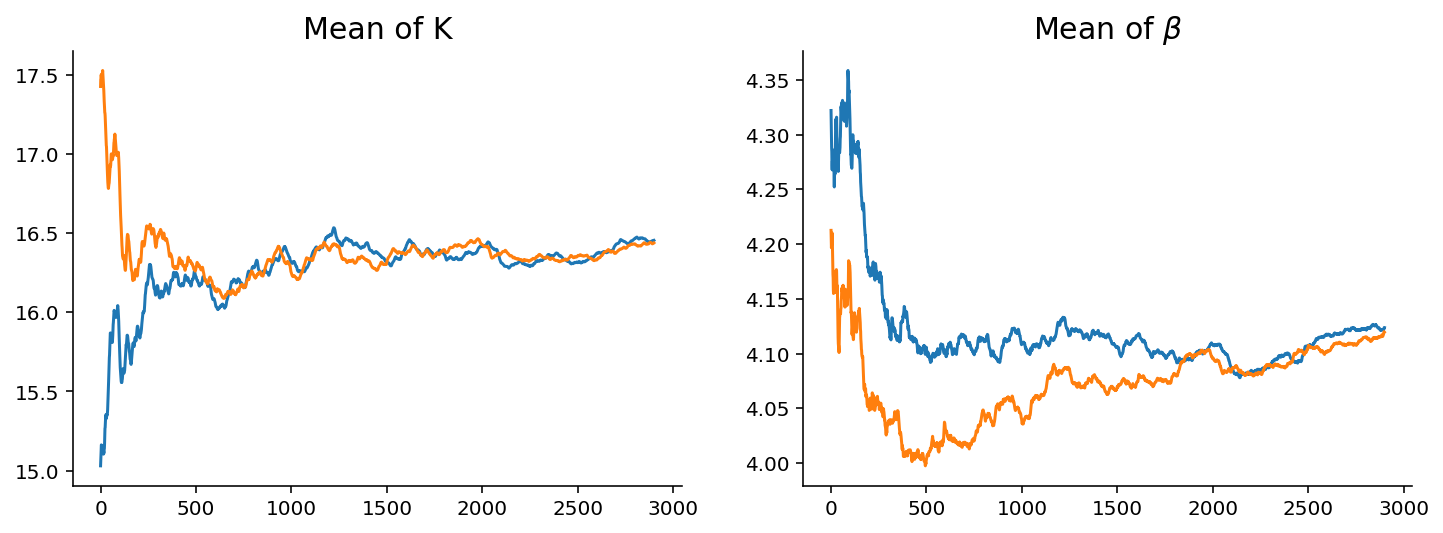

In [31]:
labels = ["K", r"$\beta$"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, (axi, label) in enumerate(zip(ax, labels)):
    axi.plot(mu_1[100:, i])
    axi.plot(mu_2[100:, i])
    axi.set_title(f"Mean of {label}", fontsize=15)

In [32]:
std_1 = np.sqrt((samples_1.cumsum(axis=1) - mu_1) ** 2 / N_range)
std_2 = np.sqrt((samples_2.cumsum(axis=1) - mu_2) ** 2 / N_range)

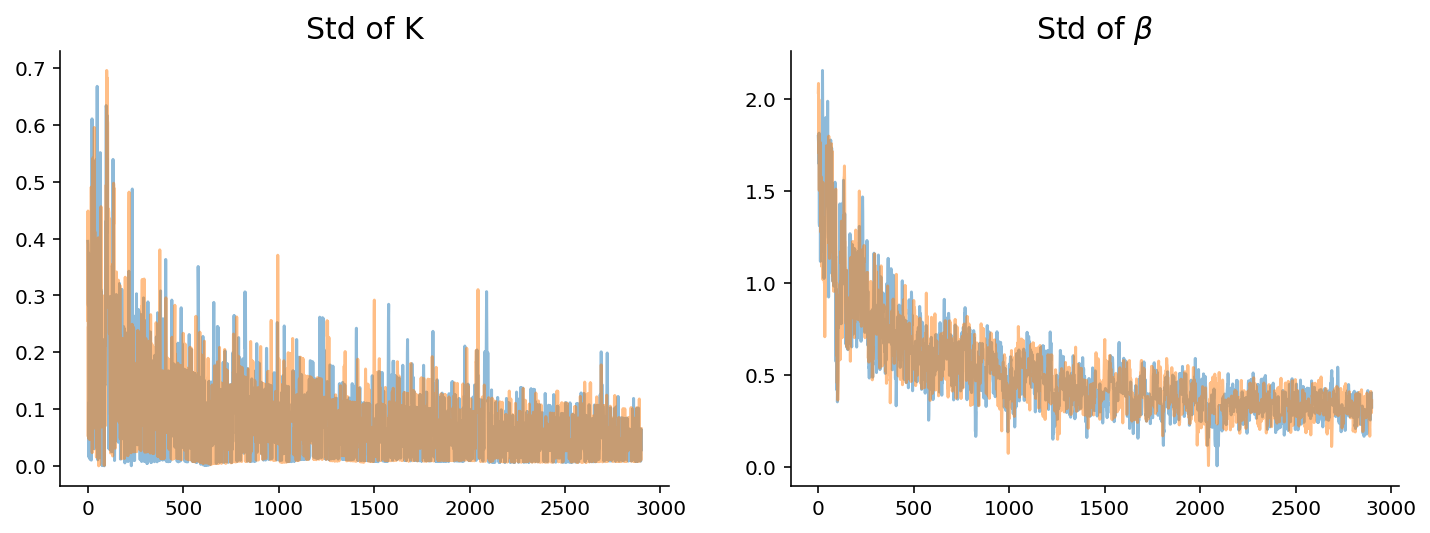

In [33]:
labels = ["K", r"$\beta$"]
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
for i, (axi, label) in enumerate(zip(ax, labels)):
    axi.plot(std_1[100:, i], alpha=0.5)
    axi.plot(std_2[100:, i], alpha=0.5)
    axi.set_title(f"Std of {label}", fontsize=15)

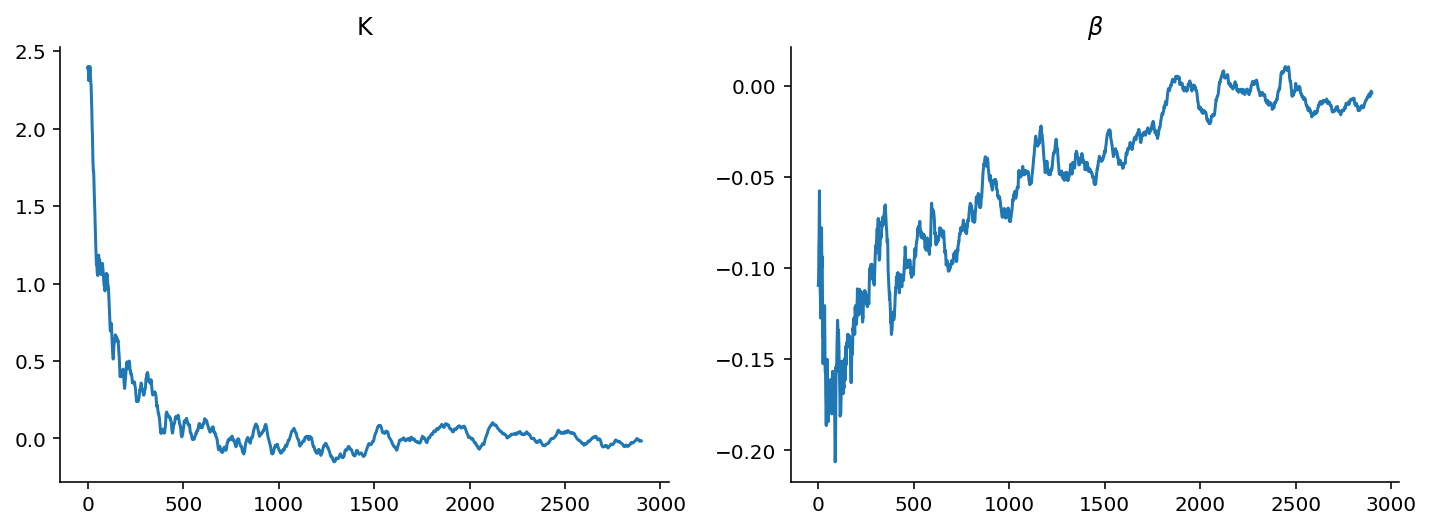

In [52]:
diffs = mu_2 - mu_1
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(diffs[100:, 0])
ax[1].plot(diffs[100:, 1])
ax[0].set_title(labels[0])
ax[1].set_title(labels[1]);

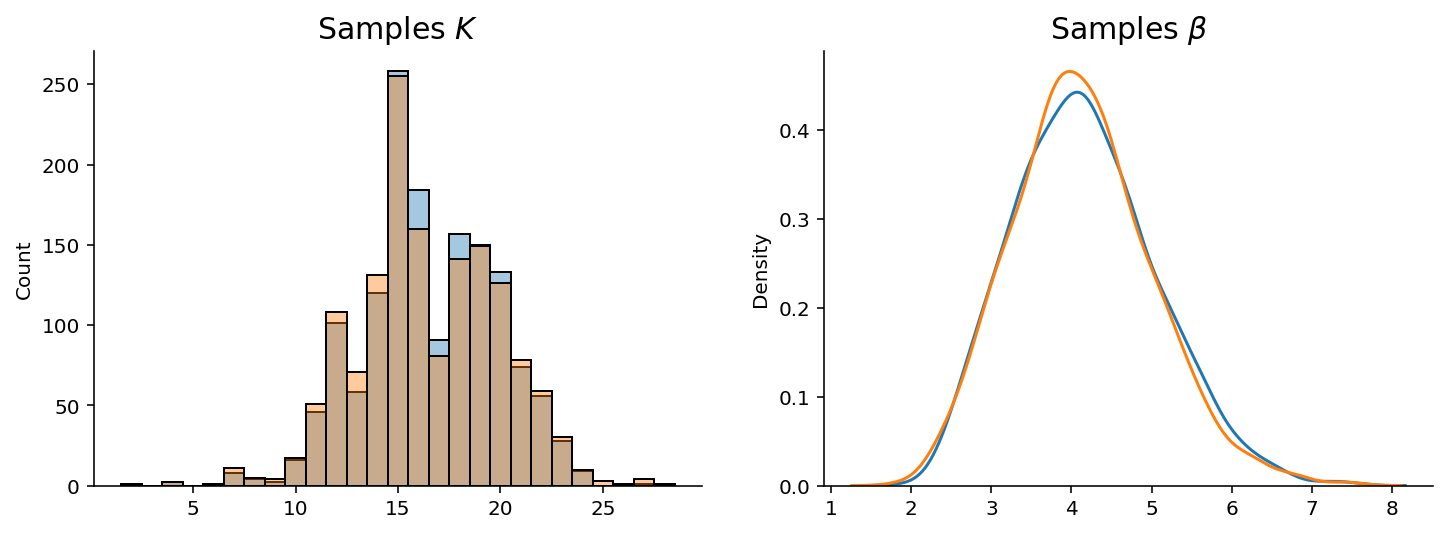

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
burnout = 1500
sns.histplot(samples_2[burnout:, 0], ax=ax[0], alpha=0.4, discrete=True)
sns.histplot(samples_1[burnout:, 0], ax=ax[0], alpha=0.4, color="tab:orange", discrete=True)

sns.kdeplot(samples_2[burnout:, 1], ax=ax[1], alpha=0.2, color="tab:blue")
sns.kdeplot(samples_1[burnout:, 1], ax=ax[1], alpha=0.2, color="tab:orange")
ax[0].set_title("Samples $K$", fontsize=15)
ax[1].set_title(r"Samples $\beta$", fontsize=15);

In [36]:
samples_mcmc = np.r_[samples_1[burnout:], samples_2[burnout:]]
samples_mcmc.shape

(3000, 2)

### The predictive distribution

$$
    p(y_{n+1}\vert {\bf x}_{n+1}, Y, X) \approx \frac{1}{I}\sum_{i=1}^Ip(y_{n + 1}\vert Y, X, \beta^{(i)}, k^{(i)})
$$

In [92]:
xmin, ymin = X.min(axis=0)
xmax, ymax = X.max(axis=0)
step = 0.1
grid = np.mgrid[xmin:xmax * 1.1:step, -1:ymax * 1.1:step]
D =((grid[..., None] - X.T[:, None, None, :]) ** 2).sum(axis=0)

In [93]:
n_samples = 1500
P_grid = np.empty(grid.shape[1:])
for k_star, beta_star in tqdm(samples_mcmc[:n_samples]):
    k_star = int(k_star)
    nearest = np.argsort(D)[..., :k_star]
    y_nearest = y[nearest]
    num = y_nearest == 1
    num = np.exp(beta_star * num.mean(axis=-1))
    
    den = y_nearest[..., None] == np.arange(Q)[None, None, None, :]
    den = np.exp(beta_star * den.mean(axis=2)).sum(axis=-1)
    
    P_grid += num / den

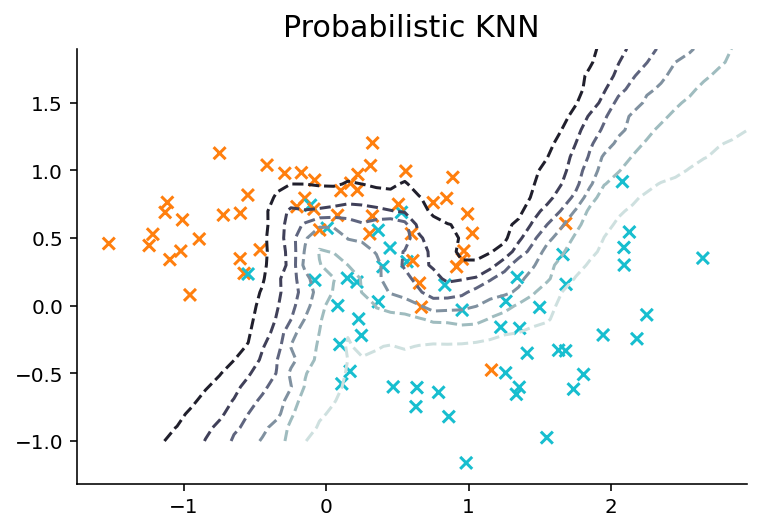

In [94]:
colors = ["tab:cyan" if yi else "tab:orange" for yi in y_cv]
plt.contour(*grid, P_grid / n_samples, cmap="bone", linestyles="--")

plt.scatter(*X_cv.T, c=colors, marker="x")
plt.title("Probabilistic KNN", fontsize=15);

## KNN v.s. PKNN

In [66]:
X_cv, y_cv = make_moons(100, noise=noise, random_state=271)

In [67]:
n_samples = 1500
p1_prob = np.empty(y_cv.shape[0])
for k_star, beta_star in tqdm(samples_mcmc[:n_samples]):
    k_star = int(k_star)
    D = np.sum((X_cv[:, None, :] - X[None, ...]) ** 2, axis=-1)
    nearest = np.argsort(D)[..., :k_star]
    y_nearest = y[nearest]
    num = np.exp(beta_star * (y_nearest == 1).mean(axis=-1))
    
    den = y_nearest[..., None] == np.arange(Q)[None, None, :]
    den = np.exp(beta_star * den.mean(axis=1)).sum(axis=-1)
    
    p1_prob += num / den
    
p1_prob = p1_prob / n_samples

In [68]:
y_hat = (p1_prob > 0.5).astype(int)

In [69]:
def knn(x, X, y, k=5):
    D = ((x[..., None] - X.T[None, ...]) ** 2).sum(axis=1)
    nearest = np.argsort(D)[..., :k]
    nearest = y[nearest].mean(axis=-1)
    return (nearest > 0.5) * 1

In [70]:
confusion_matrix(y_cv, y_hat)

array([[45,  5],
       [ 5, 45]])

In [83]:
y_hat1 = knn(X_cv, X, y, k=5)
confusion_matrix(y_cv, y_hat1)

array([[39, 11],
       [ 7, 43]])

In [85]:
precision_score(y_cv, y_hat)

0.9

In [86]:
precision_score(y_cv, y_hat1)

0.7962962962962963

## References
* [Probabilistic KNN](https://www.cc.gatech.edu/~afb/classes/CS7616-Spring2014/slides/CS7616-13a-PKNN.pdf)
* [A probabilistic nearest neighbour method for
statistical pattern recognition](http://hedibert.org/wp-content/uploads/2016/02/holmes-adams-2002.pdf)